In [2]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Download 100%.


In [3]:
! signate download --competition-id=406

sample_submission.csv

train.csv

test_data.zip

train_data.zip


Download completed.


In [4]:
! unzip -q train_data.zip 
! unzip -q test_data.zip

In [5]:
! ls

__MACOSX     sample_submission.csv  test_data.zip  train_data
sample_data  test_data		    train.csv	   train_data.zip


In [6]:
!pip install -q omegaconf timm pytorch-metric-learning[with-hooks] umap-learn record-keeper tensorboard

     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 549 kB 10.1 MB/s 
     |████████████████████████████████| 111 kB 78.3 MB/s 
     |████████████████████████████████| 88 kB 8.3 MB/s 
     |████████████████████████████████| 117 kB 73.6 MB/s 
     |████████████████████████████████| 182 kB 74.9 MB/s 
     |████████████████████████████████| 1.1 MB 67.1 MB/s 
     |████████████████████████████████| 127 kB 52.0 MB/s 
     |████████████████████████████████| 85.5 MB 63 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
signate 0.9.9 requires urllib3>=1.26.7, but you have urllib3 1.25.11 which is incompatible.


# Training

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import umap
import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as LP
from pytorch_metric_learning import miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [8]:
import os
import random
import numpy as np


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Config

In [10]:
train_master_dir = './train.csv'
img_dir = '/content/train_data'
OUTPUT_SIZE = 1024
EMBEDDING_SIZE = 512
log_dir = 'log'
tensorboard_dir = 'tensorboard'
model_dir = 'model'
patience=10
batch_size = 8
n_worker = 2
n_epoch = 100

Data

In [11]:
train_master = pd.read_csv(train_master_dir)

image_name_list = train_master['id'].values
label_list = train_master['target'].values

In [12]:
x_train, x_val, y_train, y_val = train_test_split(image_name_list, label_list, test_size=0.25, stratify=label_list, random_state=42)

Transformation

In [13]:
from torchvision import transforms


class Transforms():

    def __init__(self):
        
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize(300),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]),
            'val': transforms.Compose([
                transforms.Resize(300),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]),
            'test': transforms.Compose([
                transforms.Resize(300),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]),
            }
    
    def __call__(self, phase, img):
        """
        Parameters
        ----------
        phase : 'train' or 'val' or 'test'
        """
        return self.data_transform[phase](img)

Dataset

In [14]:
import os
from PIL import Image
from torch.utils.data import Dataset


class DefectDataset(Dataset):
    def __init__(self, image_name_list, label_list, img_dir, transform=None, phase=None):
        self.image_name_list = image_name_list
        self.label_list = label_list
        self.img_dir = img_dir
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.image_name_list)

    def __getitem__(self, index):
        image_path = os.path.join(self.img_dir, self.image_name_list[index])
        image = Image.open(image_path)
        image = self.transform(self.phase, image)
        label = self.label_list[index]
        
        return image, label

In [15]:
from omegaconf import DictConfig


def get_dataset(x_train, y_train, x_val, y_val):
    train_dataset = DefectDataset(
        image_name_list=x_train, 
        label_list=y_train,
        img_dir=img_dir,
        transform=Transforms(),
        phase='train'
    )
    val_dataset = DefectDataset(
        image_name_list=x_val, 
        label_list=y_val,
        img_dir=img_dir,
        transform=Transforms(),
        phase='val'
    )

    return train_dataset, val_dataset

In [16]:
train_dataset, val_dataset = get_dataset(x_train, y_train, x_val, y_val)

DataLoader

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Model

In [18]:
import torch
import torch.nn as nn
import timm
import pytorch_metric_learning
from pytorch_metric_learning.utils import common_functions


class ConvnextBase(nn.Module):
    def __init__(self):
        super(ConvnextBase, self).__init__()
        self.model_name = 'convnext_base'
        self.pretrained = True

        self.trunk = timm.create_model(
            self.model_name,
            pretrained=self.pretrained,
        )
        self.trunk.head.fc = common_functions.Identity()
        self.embedder = nn.Linear(OUTPUT_SIZE, EMBEDDING_SIZE)
    
    def forward(self, x):
        x = self.trunk(x)
        x = self.embedder(x)
        return x

In [19]:
model = ConvnextBase()
model = model.to(device)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


Losses

In [20]:
from pytorch_metric_learning import losses, distances, regularizers


def get_arcfaceloss():
    distance = distances.CosineSimilarity()
    regularizer = regularizers.RegularFaceRegularizer()
    loss = losses.ArcFaceLoss(
        num_classes=2,
        embedding_size=EMBEDDING_SIZE,
        margin=28.6,
        scale=64,
        weight_regularizer=regularizer, 
        distance=distance
    )
    sampler = None
    mining_funcs = dict()

    return loss, sampler, mining_funcs

In [21]:
loss, sampler, mining_funcs = get_arcfaceloss()

loss = loss.to(device)

Optimizer

In [22]:
import torch
from torch import optim


def get_optimizer(net: nn.Module):
    return optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)

In [23]:
optimizer = get_optimizer(model)
loss_optimizer = get_optimizer(loss)

In [24]:
def train(model, loss_fn, device, train_dataloader, optimizer, loss_optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_fn(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        total_loss += loss.detach().cpu().numpy()
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} iteration {batch_idx}: train_loss = {loss}")
    return total_loss

In [25]:
def test(model, loss_fn, test_dataloader, device, epoch):
    model.eval()
    with torch.no_grad():    
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(test_dataloader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(data)
            loss = loss_fn(embeddings, labels)
            total_loss += loss.detach().cpu().numpy()
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch} iteration {batch_idx}: test_loss = {loss}")
    return total_loss

In [26]:
import pytorch_metric_learning
from pytorch_metric_learning import testers


def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

In [27]:
def calculate_accuracy(train_dataset, test_dataset, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_dataset, model)
    test_embeddings, test_labels = get_all_embeddings(test_dataset, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print('Computing accuracy')
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print(f'test_Precision@1 = {accuracies["precision_at_1"]}')
    print(f'test_NMI = {accuracies["NMI"]}')
    print(f'test_AMI = {accuracies["AMI"]}')
    print(f'test_r_precision = {accuracies["r_precision"]}')
    print(f'test_mean_average_precision_at_r = {accuracies["mean_average_precision_at_r"]}')

In [28]:
accuracy_calculator = AccuracyCalculator(k='max_bin_count')

In [29]:
train_loss_history = []
val_loss_history = []
for epoch in range(1, n_epoch + 1):
    train_loss = train(model, loss, device, train_dataloader, optimizer, loss_optimizer, epoch)
    val_loss = test(model, loss, val_dataloader, device, epoch)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    calculate_accuracy(train_dataset, val_dataset, model, accuracy_calculator)

Epoch 1 iteration 0: train_loss = 32.40278244018555
Epoch 1 iteration 0: test_loss = 34.254493713378906


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.5933410549659246
test_AMI = 0.5884291223849912
test_r_precision = 0.8167063492063492
test_mean_average_precision_at_r = 0.7919720087376663
Epoch 2 iteration 0: train_loss = 11.347618103027344
Epoch 2 iteration 0: test_loss = 16.923030853271484


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 0.9841269841269841
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9253363567649281
test_mean_average_precision_at_r = 0.9167559570686068
Epoch 3 iteration 0: train_loss = 8.90140438079834
Epoch 3 iteration 0: test_loss = 0.00959698110818863


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.999858276643991
test_mean_average_precision_at_r = 0.9998408737725281
Epoch 4 iteration 0: train_loss = 0.059957802295684814
Epoch 4 iteration 0: test_loss = 0.009243573993444443


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 1.0
test_mean_average_precision_at_r = 1.0
Epoch 5 iteration 0: train_loss = 0.009243573993444443
Epoch 5 iteration 0: test_loss = 0.008805565536022186


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.8246471687366547
test_AMI = 0.8225114481387651
test_r_precision = 0.9787414965986394
test_mean_average_precision_at_r = 0.9722814853461298
Epoch 6 iteration 0: train_loss = 0.008805327117443085
Epoch 6 iteration 0: test_loss = 0.008333835750818253


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9991496598639454
test_mean_average_precision_at_r = 0.9986509913276308
Epoch 7 iteration 0: train_loss = 0.008333835750818253
Epoch 7 iteration 0: test_loss = 0.007825586944818497


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9963284202569915
test_mean_average_precision_at_r = 0.9951149858390785
Epoch 8 iteration 0: train_loss = 0.1746426820755005
Epoch 8 iteration 0: test_loss = 0.015600603073835373


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.8246471687366547
test_AMI = 0.8225114481387651
test_r_precision = 0.9682539682539681
test_mean_average_precision_at_r = 0.9620752891202685
Epoch 9 iteration 0: train_loss = 0.007489412557333708
Epoch 9 iteration 0: test_loss = 0.0069264136254787445


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 1.0
test_mean_average_precision_at_r = 1.0
Epoch 10 iteration 0: train_loss = 0.006924744695425034
Epoch 10 iteration 0: test_loss = 0.45919978618621826


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9832766439909296
test_mean_average_precision_at_r = 0.9796742159376253
Epoch 11 iteration 0: train_loss = 0.006291553378105164
Epoch 11 iteration 0: test_loss = 0.005695842206478119


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 1.0
test_mean_average_precision_at_r = 1.0
Epoch 12 iteration 0: train_loss = 0.005695842206478119
Epoch 12 iteration 0: test_loss = 0.005017589777708054


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 1.0
test_mean_average_precision_at_r = 1.0
Epoch 13 iteration 0: train_loss = 0.005017589777708054
Epoch 13 iteration 0: test_loss = 0.004284970462322235


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9997165532879819
test_mean_average_precision_at_r = 0.9996978850294117
Epoch 14 iteration 0: train_loss = 0.004284970462322235
Epoch 14 iteration 0: test_loss = 0.0035664811730384827


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 1.0
test_mean_average_precision_at_r = 1.0
Epoch 15 iteration 0: train_loss = 0.0035664811730384827
Epoch 15 iteration 0: test_loss = 0.0028427056968212128


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.999858276643991
test_mean_average_precision_at_r = 0.9998090713010578
Epoch 16 iteration 0: train_loss = 0.0028427056968212128
Epoch 16 iteration 0: test_loss = 0.0020418837666511536


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 1.0
test_mean_average_precision_at_r = 1.0
Epoch 17 iteration 0: train_loss = 0.0020418837666511536
Epoch 17 iteration 0: test_loss = 43.43667221069336


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 0.9841269841269841
test_NMI = 0.8246471687366547
test_AMI = 0.8225114481387651
test_r_precision = 0.9787414965986394
test_mean_average_precision_at_r = 0.9722588491622295
Epoch 18 iteration 0: train_loss = 0.001199275255203247
Epoch 18 iteration 0: test_loss = 0.00034984559169970453


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.999858276643991
test_mean_average_precision_at_r = 0.9997447609353242
Epoch 19 iteration 0: train_loss = 0.00034389967913739383
Epoch 19 iteration 0: test_loss = 1.821179986000061


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9974489795918366
test_mean_average_precision_at_r = 0.9960658032209144
Epoch 20 iteration 0: train_loss = -0.0005770549178123474
Epoch 20 iteration 0: test_loss = 3.6397058963775635


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9940209478230653
Epoch 21 iteration 0: train_loss = -0.0015112049877643585
Epoch 21 iteration 0: test_loss = 3.8092498779296875


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9964569160997732
test_mean_average_precision_at_r = 0.9942799698005871
Epoch 22 iteration 0: train_loss = -0.002472139894962311
Epoch 22 iteration 0: test_loss = 3.833646774291992


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9944324296444605
Epoch 23 iteration 0: train_loss = -0.0034598372876644135
Epoch 23 iteration 0: test_loss = 3.8383736610412598


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9946928114056263
Epoch 24 iteration 0: train_loss = -0.004474040120840073
Epoch 24 iteration 0: test_loss = 3.8420968055725098


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9967403628117913
test_mean_average_precision_at_r = 0.9951423160001801
Epoch 25 iteration 0: train_loss = -0.0055144429206848145
Epoch 25 iteration 0: test_loss = 3.862520694732666


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996315192743764
test_mean_average_precision_at_r = 0.994301481919315
Epoch 26 iteration 0: train_loss = -0.006580624729394913
Epoch 26 iteration 0: test_loss = 3.877103805541992


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9964569160997732
test_mean_average_precision_at_r = 0.9945219098863687
Epoch 27 iteration 0: train_loss = -0.007672544568777084
Epoch 27 iteration 0: test_loss = 3.878789186477661


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9939029455133209
Epoch 28 iteration 0: train_loss = -0.008789647370576859
Epoch 28 iteration 0: test_loss = 3.8789360523223877


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.993956404167968
Epoch 29 iteration 0: train_loss = -0.009931877255439758
Epoch 29 iteration 0: test_loss = 3.8868908882141113


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9965986394557822
test_mean_average_precision_at_r = 0.9945026534691852
Epoch 30 iteration 0: train_loss = -0.011098884046077728
Epoch 30 iteration 0: test_loss = 3.8974246978759766


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9960317460317459
test_mean_average_precision_at_r = 0.9940147894266197
Epoch 31 iteration 0: train_loss = -0.012290511280298233
Epoch 31 iteration 0: test_loss = 3.9052748680114746


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9939639913996087
Epoch 32 iteration 0: train_loss = -0.013506494462490082
Epoch 32 iteration 0: test_loss = 3.9161016941070557


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996315192743764
test_mean_average_precision_at_r = 0.9942778771433001
Epoch 33 iteration 0: train_loss = -0.014746680855751038
Epoch 33 iteration 0: test_loss = 3.9179227352142334


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9941071522646777
Epoch 34 iteration 0: train_loss = -0.016010895371437073
Epoch 34 iteration 0: test_loss = 3.918123245239258


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9938998884379291
Epoch 35 iteration 0: train_loss = -0.017298895865678787
Epoch 35 iteration 0: test_loss = 3.9181244373321533


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9967403628117913
test_mean_average_precision_at_r = 0.9943504412595058
Epoch 36 iteration 0: train_loss = -0.018610570579767227
Epoch 36 iteration 0: test_loss = 3.9183602333068848


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9967403628117913
test_mean_average_precision_at_r = 0.9949381599163406
Epoch 37 iteration 0: train_loss = -0.01994573324918747
Epoch 37 iteration 0: test_loss = 3.9189205169677734


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9936454378038919
Epoch 38 iteration 0: train_loss = -0.02130424976348877
Epoch 38 iteration 0: test_loss = 3.925959348678589


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9940036753895416
Epoch 39 iteration 0: train_loss = -0.022674642503261566
Epoch 39 iteration 0: test_loss = 3.941920280456543


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9938787207560389
Epoch 40 iteration 0: train_loss = -0.02409077063202858
Epoch 40 iteration 0: test_loss = 3.9439468383789062


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9960317460317459
test_mean_average_precision_at_r = 0.9941739566019373
Epoch 41 iteration 0: train_loss = -0.02551845833659172
Epoch 41 iteration 0: test_loss = 3.9448206424713135


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9964569160997732
test_mean_average_precision_at_r = 0.9948462457374871
Epoch 42 iteration 0: train_loss = -0.02696891501545906
Epoch 42 iteration 0: test_loss = 3.9453463554382324


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996315192743764
test_mean_average_precision_at_r = 0.9947814918599012
Epoch 43 iteration 0: train_loss = -0.02844204381108284
Epoch 43 iteration 0: test_loss = 3.9459316730499268


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9939905444287666
Epoch 44 iteration 0: train_loss = -0.029937636107206345
Epoch 44 iteration 0: test_loss = 3.9462366104125977


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9940225150625772
Epoch 45 iteration 0: train_loss = -0.03145577386021614
Epoch 45 iteration 0: test_loss = 3.947017192840576


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.993842498248204
Epoch 46 iteration 0: train_loss = -0.03299613296985626
Epoch 46 iteration 0: test_loss = 3.956281900405884


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9967403628117913
test_mean_average_precision_at_r = 0.9947349264678241
Epoch 47 iteration 0: train_loss = -0.03455863893032074
Epoch 47 iteration 0: test_loss = 3.95893931388855


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996315192743764
test_mean_average_precision_at_r = 0.9946307149557828
Epoch 48 iteration 0: train_loss = -0.036143239587545395
Epoch 48 iteration 0: test_loss = 3.959373712539673


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9943298712388001
Epoch 49 iteration 0: train_loss = -0.03774977847933769
Epoch 49 iteration 0: test_loss = 3.965796947479248


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9937826968319458
Epoch 50 iteration 0: train_loss = -0.03937810659408569
Epoch 50 iteration 0: test_loss = 3.9811675548553467


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9958900226757369
test_mean_average_precision_at_r = 0.9942511982073773
Epoch 51 iteration 0: train_loss = -0.04102826490998268
Epoch 51 iteration 0: test_loss = 3.9913394451141357


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9958900226757369
test_mean_average_precision_at_r = 0.9934994634525735
Epoch 52 iteration 0: train_loss = -0.042700011283159256
Epoch 52 iteration 0: test_loss = 4.003411293029785


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9960317460317459
test_mean_average_precision_at_r = 0.9940722362615602
Epoch 53 iteration 0: train_loss = -0.04439326375722885
Epoch 53 iteration 0: test_loss = 4.012248516082764


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9960317460317459
test_mean_average_precision_at_r = 0.9938603520507253
Epoch 54 iteration 0: train_loss = -0.04610787704586983
Epoch 54 iteration 0: test_loss = 4.021291255950928


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9941825733923179
Epoch 55 iteration 0: train_loss = -0.04784388840198517
Epoch 55 iteration 0: test_loss = 4.024850845336914


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9960317460317459
test_mean_average_precision_at_r = 0.9937078833926011
Epoch 56 iteration 0: train_loss = -0.04960101842880249
Epoch 56 iteration 0: test_loss = 4.025341510772705


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.9960317460317459
test_mean_average_precision_at_r = 0.9939005759954516
Epoch 57 iteration 0: train_loss = -0.0513790100812912
Epoch 57 iteration 0: test_loss = 4.027858734130859


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 1.0
test_AMI = 1.0
test_r_precision = 0.996315192743764
test_mean_average_precision_at_r = 0.9943998236738201
Epoch 58 iteration 0: train_loss = -0.05317853018641472
Epoch 58 iteration 0: test_loss = 4.042906284332275


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.9931082631997602
Epoch 59 iteration 0: train_loss = -0.05499862879514694
Epoch 59 iteration 0: test_loss = 4.051115989685059


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9960317460317459
test_mean_average_precision_at_r = 0.9933836046531928
Epoch 60 iteration 0: train_loss = -0.056839555501937866
Epoch 60 iteration 0: test_loss = 4.054428577423096


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9958900226757369
test_mean_average_precision_at_r = 0.9936134821536712
Epoch 61 iteration 0: train_loss = -0.05870111286640167
Epoch 61 iteration 0: test_loss = 4.054966449737549


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9938475365129137
Epoch 62 iteration 0: train_loss = -0.06058330088853836
Epoch 62 iteration 0: test_loss = 4.055172920227051


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9958900226757369
test_mean_average_precision_at_r = 0.993668885761022
Epoch 63 iteration 0: train_loss = -0.06248592212796211
Epoch 63 iteration 0: test_loss = 4.0619001388549805


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9958900226757369
test_mean_average_precision_at_r = 0.9937195910709254
Epoch 64 iteration 0: train_loss = -0.06440886110067368
Epoch 64 iteration 0: test_loss = 4.063995838165283


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9958900226757369
test_mean_average_precision_at_r = 0.9935754935306954
Epoch 65 iteration 0: train_loss = -0.06635209918022156
Epoch 65 iteration 0: test_loss = 4.0666375160217285


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9938456757481721
Epoch 66 iteration 0: train_loss = -0.06831548362970352
Epoch 66 iteration 0: test_loss = 4.07253360748291


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9958900226757369
test_mean_average_precision_at_r = 0.9939276979182319
Epoch 67 iteration 0: train_loss = -0.07029888033866882
Epoch 67 iteration 0: test_loss = 4.073514938354492


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.994108540686765
Epoch 68 iteration 0: train_loss = -0.0723022073507309
Epoch 68 iteration 0: test_loss = 4.074341297149658


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9937247431307441
Epoch 69 iteration 0: train_loss = -0.07432535290718079
Epoch 69 iteration 0: test_loss = 4.074581146240234


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9932992757254308
Epoch 70 iteration 0: train_loss = -0.07636815309524536
Epoch 70 iteration 0: test_loss = 4.079063415527344


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.996173469387755
test_mean_average_precision_at_r = 0.9940411138711608
Epoch 71 iteration 0: train_loss = -0.07843058556318283
Epoch 71 iteration 0: test_loss = 4.082625389099121


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.9931539803332419
Epoch 72 iteration 0: train_loss = -0.08051243424415588
Epoch 72 iteration 0: test_loss = 4.0831122398376465


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.9935555534750938
Epoch 73 iteration 0: train_loss = -0.08261366933584213
Epoch 73 iteration 0: test_loss = 4.0901594161987305


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9954648526077097
test_mean_average_precision_at_r = 0.9931260922695611
Epoch 74 iteration 0: train_loss = -0.08473414927721024
Epoch 74 iteration 0: test_loss = 4.097422122955322


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9954648526077097
test_mean_average_precision_at_r = 0.9934391235803717
Epoch 75 iteration 0: train_loss = -0.08687368035316467
Epoch 75 iteration 0: test_loss = 4.098926067352295


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9960317460317459
test_mean_average_precision_at_r = 0.9940632834395842
Epoch 76 iteration 0: train_loss = -0.08903226256370544
Epoch 76 iteration 0: test_loss = 4.099637508392334


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.9933062860606807
Epoch 77 iteration 0: train_loss = -0.09120972454547882
Epoch 77 iteration 0: test_loss = 4.10521125793457


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9954648526077097
test_mean_average_precision_at_r = 0.9929770498670877
Epoch 78 iteration 0: train_loss = -0.09340590983629227
Epoch 78 iteration 0: test_loss = 4.113292694091797


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9938781965809168
Epoch 79 iteration 0: train_loss = -0.09562067687511444
Epoch 79 iteration 0: test_loss = 4.114527702331543


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.9935080183883771
Epoch 80 iteration 0: train_loss = -0.09785397350788116
Epoch 80 iteration 0: test_loss = 4.12052583694458


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9954648526077097
test_mean_average_precision_at_r = 0.993563840092438
Epoch 81 iteration 0: train_loss = -0.10010562092065811
Epoch 81 iteration 0: test_loss = 4.123195171356201


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9958900226757369
test_mean_average_precision_at_r = 0.9935726073778589
Epoch 82 iteration 0: train_loss = -0.10237547010183334
Epoch 82 iteration 0: test_loss = 4.13253116607666


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.9931270567207273
Epoch 83 iteration 0: train_loss = -0.1046634316444397
Epoch 83 iteration 0: test_loss = 4.134574890136719


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9954648526077097
test_mean_average_precision_at_r = 0.9929981503428849
Epoch 84 iteration 0: train_loss = -0.10696933418512344
Epoch 84 iteration 0: test_loss = 4.139688968658447


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9935348984883996
Epoch 85 iteration 0: train_loss = -0.10929311066865921
Epoch 85 iteration 0: test_loss = 4.144747734069824


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9954648526077097
test_mean_average_precision_at_r = 0.9930347490544937
Epoch 86 iteration 0: train_loss = -0.1116345003247261
Epoch 86 iteration 0: test_loss = 4.151975154876709


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.9935790292776434
Epoch 87 iteration 0: train_loss = -0.11399351060390472
Epoch 87 iteration 0: test_loss = 4.157953262329102


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9958900226757369
test_mean_average_precision_at_r = 0.9935540439236777
Epoch 88 iteration 0: train_loss = -0.11636984348297119
Epoch 88 iteration 0: test_loss = 4.162266731262207


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9933728614665488
Epoch 89 iteration 0: train_loss = -0.11876348406076431
Epoch 89 iteration 0: test_loss = 4.170171737670898


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9937379919399673
Epoch 90 iteration 0: train_loss = -0.12117420136928558
Epoch 90 iteration 0: test_loss = 4.170400619506836


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.993254683526317
Epoch 91 iteration 0: train_loss = -0.12360192835330963
Epoch 91 iteration 0: test_loss = 4.1753010749816895


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9936616806533769
Epoch 92 iteration 0: train_loss = -0.12604635953903198
Epoch 92 iteration 0: test_loss = 4.180335998535156


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9938296419880769
Epoch 93 iteration 0: train_loss = -0.1285075694322586
Epoch 93 iteration 0: test_loss = 4.180997371673584


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9953231292517005
test_mean_average_precision_at_r = 0.9933007274256993
Epoch 94 iteration 0: train_loss = -0.13098521530628204
Epoch 94 iteration 0: test_loss = 4.180712699890137


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.993959649934565
Epoch 95 iteration 0: train_loss = -0.13347917795181274
Epoch 95 iteration 0: test_loss = 4.182982444763184


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.993260988686292
Epoch 96 iteration 0: train_loss = -0.13598938286304474
Epoch 96 iteration 0: test_loss = 4.186136245727539


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9957482993197279
test_mean_average_precision_at_r = 0.9931910058565616
Epoch 97 iteration 0: train_loss = -0.13851560652256012
Epoch 97 iteration 0: test_loss = 4.187320709228516


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9954648526077097
test_mean_average_precision_at_r = 0.9929715306024722
Epoch 98 iteration 0: train_loss = -0.14105769991874695
Epoch 98 iteration 0: test_loss = 4.191667079925537


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9954648526077097
test_mean_average_precision_at_r = 0.9933286006833475
Epoch 99 iteration 0: train_loss = -0.1436154544353485
Epoch 99 iteration 0: test_loss = 4.1918158531188965


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9953231292517005
test_mean_average_precision_at_r = 0.9933986207815894
Epoch 100 iteration 0: train_loss = -0.14618879556655884
Epoch 100 iteration 0: test_loss = 4.195676326751709


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Computing accuracy
test_Precision@1 = 1.0
test_NMI = 0.895755222923823
test_AMI = 0.8944802104056611
test_r_precision = 0.9956065759637187
test_mean_average_precision_at_r = 0.9931504716986272


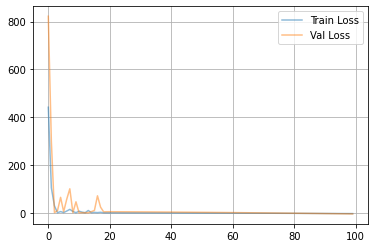

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, alpha=0.5, label="Train Loss")
plt.plot(val_loss_history, alpha=0.5, label="Val Loss")
plt.grid()
plt.legend()
plt.show()